In [ ]:
def analyze_pdb_ligands(downloaded_pdbs):
    """
    Analyzes PDB files to identify and categorize specific ligand types
    including hemes, iron-sulfur clusters, hormones, and DNA chains.
    """
    # Define ligand identifiers
    heme_ids = ['HEM', 'HEA', 'HEB', 'HEC', 'HDD', 'HDM']
    iron_sulfur_ids = ['FES', 'SF4', 'F3S', 'FS4', 'FS3', 'FS2']
    hormone_ids = ['EST', 'TST', 'INS', 'T3', 'T4', 'GCG', 'EPO']
    
    results = []
    
    print("Analyzing downloaded PDB files for specific ligand types...")
    for pdb_file in tqdm(downloaded_pdbs):
        pdb_id = os.path.basename(pdb_file).split('.')[0]
        
        # Initialize ligand count dictionary
        ligand_info = {
            'pdb_id': pdb_id,
            'file_path': pdb_file,
            'has_heme': False,
            'has_iron_sulfur': False,
            'has_hormone': False,
            'has_dna': False,
            'ligand_list': []
        }
        
        try:
            with open(pdb_file, 'r') as f:
                content = f.readlines()
                
            for line in content:
                # Check for HETATM records (ligands)
                if line.startswith('HETATM'):
                    ligand_id = line[17:20].strip()
                    if ligand_id not in ligand_info['ligand_list']:
                        ligand_info['ligand_list'].append(ligand_id)
                    
                    if ligand_id in heme_ids:
                        ligand_info['has_heme'] = True
                    if ligand_id in iron_sulfur_ids:
                        ligand_info['has_iron_sulfur'] = True
                    if ligand_id in hormone_ids:
                        ligand_info['has_hormone'] = True
                
                # Check for DNA chains
                elif line.startswith('ATOM') and 'DA ' in line or 'DG ' in line or 'DC ' in line or 'DT ' in line:
                    ligand_info['has_dna'] = True
        
        except Exception as e:
            print(f"Error analyzing {pdb_id}: {e}")
            continue
        
        results.append(ligand_info)
    
    # Convert to DataFrame
    df = pd.DataFrame(results)
    
    # Add summary column
    df['ligand_types'] = ''
    for idx, row in df.iterrows():
        types = []
        if row['has_heme']:
            types.append('Heme')
        if row['has_iron_sulfur']:
            types.append('Iron-Sulfur')
        if row['has_hormone']:
            types.append('Hormone')
        if row['has_dna']:
            types.append('DNA')
        
        df.at[idx, 'ligand_types'] = ', '.join(types) if types else 'Other'
    
    return df

# Analyze the downloaded PDB files
ligand_analysis_df = analyze_pdb_ligands(downloaded_pdbs)

# Display the results
print("PDB files with specific ligand types:")
print(ligand_analysis_df[['pdb_id', 'ligand_types', 'ligand_list']])

# Count distribution of ligand types
ligand_type_counts = {
    'Heme': ligand_analysis_df['has_heme'].sum(),
    'Iron-Sulfur': ligand_analysis_df['has_iron_sulfur'].sum(),
    'Hormone': ligand_analysis_df['has_hormone'].sum(),
    'DNA': ligand_analysis_df['has_dna'].sum(),
    'Other': len(ligand_analysis_df) - (
        ligand_analysis_df['has_heme'] | 
        ligand_analysis_df['has_iron_sulfur'] | 
        ligand_analysis_df['has_hormone'] | 
        ligand_analysis_df['has_dna']
    ).sum()
}

print("\nLigand type distribution:")
for ligand_type, count in ligand_type_counts.items():
    print(f"{ligand_type}: {count} structures")

Fetching PDB entries list...
Found 233605 total PDB entries
Checking for entries with ligands...


100%|██████████| 2/2 [01:03<00:00, 31.63s/it]


Found 771 entries with ligands


100%|██████████| 10/10 [00:06<00:00,  1.47it/s]

Successfully downloaded 10 PDB files
Downloaded PDB files with ligands:
  pdb_id           file_path
0   100D  pdb_files\100D.pdb
1   1FT5  pdb_files\1FT5.pdb
2   1GSE  pdb_files\1GSE.pdb
3   1HSH  pdb_files\1HSH.pdb
4   1ISO  pdb_files\1ISO.pdb
5   1JSR  pdb_files\1JSR.pdb
6   1KSE  pdb_files\1KSE.pdb
7   1LTV  pdb_files\1LTV.pdb
8   1NUU  pdb_files\1NUU.pdb
9   1OUJ  pdb_files\1OUJ.pdb


In [ ]:
import torch
import numpy as np
from typing import Dict, List, Tuple, Optional

import torch.nn as nn
import torch.nn.functional as F

class SinusoidalPositionEmbeddings(nn.Module):
    """Sinusoidal position embeddings for diffusion timesteps."""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=time.device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((torch.sin(embeddings), torch.cos(embeddings)), dim=-1)
        return embeddings

class LigandEncoder(nn.Module):
    """Encodes ligand structure with atom positions and functional properties."""
    def __init__(self, hidden_dim=128, num_functions=4):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_functions = num_functions  # hydrophobic, aromatic, charge, sterics
        
        # Position and feature encodings
        self.pos_encoder = nn.Sequential(
            nn.Linear(3, hidden_dim),  # 3D coordinates
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        self.func_encoder = nn.Sequential(
            nn.Linear(num_functions, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        self.combine = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
    def forward(self, atom_pos, atom_features):
        """
        Args:
            atom_pos: [B, N, 3] - positions of ligand atoms
            atom_features: [B, N, num_functions] - functional properties
        Returns:
            encoded: [B, N, hidden_dim] - encoded ligand representation
        """
        pos_encoding = self.pos_encoder(atom_pos)
        func_encoding = self.func_encoder(atom_features)
        combined = torch.cat([pos_encoding, func_encoding], dim=-1)
        return self.combine(combined)

class AttentionBlock(nn.Module):
    """Self-attention block for processing 3D structures."""
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.heads = heads
        self.scale = dim_head ** -0.5
        inner_dim = dim_head * heads
        
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(0.1)
        )
        
    def forward(self, x):
        b, n, d = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: t.reshape(b, n, self.heads, -1).transpose(1, 2), qkv)
        
        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = F.softmax(dots, dim=-1)
        
        out = torch.matmul(attn, v)
        out = out.transpose(1, 2).reshape(b, n, -1)
        return self.to_out(out)

class ProteinDiffusionModel(nn.Module):
    """Diffusion model for protein backbone generation around a ligand."""
    def __init__(
        self, 
        protein_dim=256,  # Protein backbone features
        hidden_dim=256,
        ligand_dim=128,
        timestep_dim=128,
        depth=6,
        num_functions=4,  # hydrophobic, aromatic, charge, sterics
        max_protein_length=500
    ):
        super().__init__()
        self.protein_dim = protein_dim
        self.hidden_dim = hidden_dim
        self.ligand_dim = ligand_dim
        self.max_protein_length = max_protein_length
        self.num_functions = num_functions
        
        # Encoders
        self.time_embedder = SinusoidalPositionEmbeddings(timestep_dim)
        self.ligand_encoder = LigandEncoder(ligand_dim, num_functions)
        
        # Initial projections
        self.protein_pos_embed = nn.Linear(3, protein_dim // 2)  # 3D coordinates
        self.protein_feat_embed = nn.Linear(num_functions, protein_dim // 2)  # Functional properties
        
        # Position encoding for transformer
        self.pos_encoding = nn.Parameter(torch.randn(1, max_protein_length, hidden_dim))
        
        # Process ligand context
        self.ligand_context_proj = nn.Sequential(
            nn.Linear(ligand_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # Time projection
        self.time_proj = nn.Sequential(
            nn.Linear(timestep_dim, hidden_dim),
            nn.SiLU()
        )
        
        # Attention layers
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                nn.LayerNorm(hidden_dim),
                AttentionBlock(hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.Sequential(
                    nn.Linear(hidden_dim, hidden_dim * 2),
                    nn.SiLU(),
                    nn.Dropout(0.1),
                    nn.Linear(hidden_dim * 2, hidden_dim)
                )
            ]))
            
        # Output projections
        self.to_pos = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, 3)  # 3D coordinates
        )
        
        self.to_feat = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, num_functions)  # Functional properties
        )
        
        self.to_confidence = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()  # Probability of residue being present
        )
        
    def forward(
        self, 
        protein_pos, 
        protein_features, 
        ligand_pos, 
        ligand_features,
        timesteps,
        protein_mask=None
    ):
        """
        Args:
            protein_pos: [B, M, 3] - noisy backbone positions 
            protein_features: [B, M, num_functions] - noisy functional features
            ligand_pos: [B, N, 3] - ligand atom positions
            ligand_features: [B, N, num_functions] - ligand functional properties
            timesteps: [B] - diffusion timesteps
            protein_mask: [B, M] - mask for valid protein positions
            
        Returns:
            pred_pos: [B, M, 3] - predicted positions
            pred_features: [B, M, num_functions] - predicted functional features
            pred_confidence: [B, M, 1] - predicted backbone presence probability
        """
        batch, protein_len = protein_pos.shape[:2]
        
        # Encode timesteps
        time_embed = self.time_embedder(timesteps)
        time_embed = self.time_proj(time_embed).unsqueeze(1)  # [B, 1, D]
        
        # Encode ligand
        ligand_embed = self.ligand_encoder(ligand_pos, ligand_features)  # [B, N, ligand_dim]
        ligand_context = self.ligand_context_proj(ligand_embed)  # [B, N, hidden_dim]
        
        # Encode protein
        protein_pos_embed = self.protein_pos_embed(protein_pos)  # [B, M, D/2]
        protein_feat_embed = self.protein_feat_embed(protein_features)  # [B, M, D/2]
        
        # Combine protein features
        x = torch.cat([protein_pos_embed, protein_feat_embed], dim=-1)  # [B, M, D]
        
        # Add positional encoding
        pos_encoding = self.pos_encoding[:, :protein_len]
        x = x + pos_encoding
        
        # Add time embedding
        x = x + time_embed
        
        # Combined context: protein + ligand
        context = torch.cat([x, ligand_context], dim=1)  # [B, M+N, D]
        
        # Create attention mask including protein mask if provided
        if protein_mask is not None:
            # Create extended mask for combined sequence
            ligand_mask = torch.ones(batch, ligand_context.shape[1], device=protein_mask.device)
            combined_mask = torch.cat([protein_mask, ligand_mask], dim=1)
            attn_mask = combined_mask.unsqueeze(1) * combined_mask.unsqueeze(2)
        else:
            attn_mask = None
            
        # Process through transformer layers
        for norm1, attn, norm2, ff in self.layers:
            # Self-attention with context
            context = context + attn(norm1(context))
            # Feedforward
            context = context + ff(norm2(context))
            
        # Extract protein features (without ligand context)
        protein_features = context[:, :protein_len]
        
        # Output predictions
        pred_pos = self.to_pos(protein_features)
        pred_features = self.to_feat(protein_features)
        pred_confidence = self.to_confidence(protein_features)
        
        return pred_pos, pred_features, pred_confidence
    
class ProteinDiffusion:
    """Manages the diffusion process for protein generation around a ligand."""
    def __init__(
        self,
        model,
        num_timesteps=1000,
        beta_start=1e-4,
        beta_end=0.02
    ):
        self.model = model
        self.num_timesteps = num_timesteps
        
        # Define beta schedule
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        
        # Pre-compute diffusion parameters
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1 / self.alphas_cumprod - 1)
        
    def add_noise(self, x_start, t, noise=None):
        """Add noise to data according to diffusion schedule."""
        if noise is None:
            noise = torch.randn_like(x_start)
            
        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t].reshape(-1, 1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].reshape(-1, 1, 1)
        
        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
    
    def sample_timesteps(self, batch_size, device):
        """Sample random timesteps for a batch."""
        return torch.randint(0, self.num_timesteps, (batch_size,), device=device, dtype=torch.long)
    
    def training_losses(self, protein_pos, protein_features, ligand_pos, ligand_features, protein_mask=None):
        """Calculate training losses for a single batch."""
        batch_size = protein_pos.shape[0]
        device = protein_pos.device
        
        # Sample random timesteps
        t = self.sample_timesteps(batch_size, device)
        
        # Add noise to positions and features
        pos_noise = torch.randn_like(protein_pos)
        feat_noise = torch.randn_like(protein_features)
        
        noisy_pos = self.add_noise(protein_pos, t, pos_noise)
        noisy_features = self.add_noise(protein_features, t, feat_noise)
        
        # Get model predictions
        pred_pos, pred_features, pred_confidence = self.model(
            noisy_pos, noisy_features, ligand_pos, ligand_features, t, protein_mask
        )
        
        # Calculate losses
        pos_loss = F.mse_loss(pred_pos, pos_noise, reduction='none')
        feat_loss = F.mse_loss(pred_features, feat_noise, reduction='none')
        
        # If mask is provided, apply it to the losses
        if protein_mask is not None:
            mask = protein_mask.unsqueeze(-1)
            pos_loss = pos_loss * mask
            feat_loss = feat_loss * mask
            
            # Confidence loss - predict 1 for valid positions
            conf_loss = F.binary_cross_entropy(
                pred_confidence, mask.float(), reduction='sum'
            ) / (mask.sum() + 1e-8)
        else:
            conf_loss = 0
            
        pos_loss = pos_loss.mean()
        feat_loss = feat_loss.mean()
        
        total_loss = pos_loss + feat_loss + conf_loss
        
        return total_loss, {
            'position_loss': pos_loss.item(),
            'feature_loss': feat_loss.item(),
            'confidence_loss': conf_loss if isinstance(conf_loss, int) else conf_loss.item()
        }
    
    @torch.no_grad()
    def sample(self, ligand_pos, ligand_features, protein_length, device, guidance_scale=1.0):
        """Generate a protein structure around a ligand using DDPM sampling."""
        batch_size = ligand_pos.shape[0]
        
        # Initialize with random noise
        protein_pos = torch.randn(batch_size, protein_length, 3, device=device)
        protein_features = torch.randn(batch_size, protein_length, self.model.num_functions, device=device)
        
        # Sample protein structure by denoising
        for t in reversed(range(0, self.num_timesteps)):
            timesteps = torch.full((batch_size,), t, device=device, dtype=torch.long)
            
            # Model prediction
            pred_pos, pred_features, pred_confidence = self.model(
                protein_pos, protein_features, ligand_pos, ligand_features, timesteps
            )
            
            # Get alpha values for current timestep
            alpha = self.alphas[t]
            alpha_cumprod = self.alphas_cumprod[t]
            
            # Calculate sampling parameters
            beta = self.betas[t]
            sqrt_one_minus_alphas_cumprod = self.sqrt_one_minus_alphas_cumprod[t]
            
            if t > 0:
                noise_pos = torch.randn_like(protein_pos)
                noise_features = torch.randn_like(protein_features)
            else:
                noise_pos = torch.zeros_like(protein_pos)
                noise_features = torch.zeros_like(protein_features)
            
            # Update position and features
            protein_pos = (1 / torch.sqrt(alpha)) * (
                protein_pos - ((1 - alpha) / sqrt_one_minus_alphas_cumprod) * pred_pos
            ) + torch.sqrt(beta) * noise_pos
            
            protein_features = (1 / torch.sqrt(alpha)) * (
                protein_features - ((1 - alpha) / sqrt_one_minus_alphas_cumprod) * pred_features
            ) + torch.sqrt(beta) * noise_features
        
        # Final confidence to determine actual structure
        _, _, final_confidence = self.model(
            protein_pos, protein_features, ligand_pos, ligand_features, 
            torch.zeros(batch_size, device=device, dtype=torch.long)
        )
        
        # Create mask based on confidence (threshold can be tuned)
        confidence_threshold = 0.5
        protein_mask = (final_confidence > confidence_threshold).squeeze(-1)
        
        return protein_pos, protein_features, protein_mask, final_confidence

In [7]:
#!pip install numpy matplotlib scipy scikit-learn py3dmol rdkit trimesh 
#!pip install conda

!conda install -c bioconda msms

'conda' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser
from scipy.spatial import ConvexHull, Delaunay
from sklearn.manifold import MDS
import py3Dmol

from skimage import measure
import tempfile
import os

def load_molecule(pdb_file):
    """Load a molecule from PDB file and return atom coordinates and radii"""
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('molecule', pdb_file)
    
    # Extract coordinates and assign van der Waals radii based on atom type
    # Common vdW radii in Angstroms
    vdw_radii = {
        'H': 1.20, 'C': 1.70, 'N': 1.55, 'O': 1.52, 'P': 1.80, 'S': 1.80,
        'F': 1.47, 'CL': 1.75, 'BR': 1.85, 'I': 1.98
    }
    
    coords = []
    radii = []
    
    for atom in structure.get_atoms():
        coords.append(atom.get_coord())
        element = atom.element.upper()
        # Default to carbon radius if element not in dictionary
        radius = vdw_radii.get(element, 1.70)
        radii.append(radius)
    
    return np.array(coords), np.array(radii)

def generate_molecular_surface(coords, radii, probe_radius=1.4, grid_spacing=0.5):
    """
    Generate a molecular surface using grid-based methods
    
    Args:
        coords: Atomic coordinates
        radii: Atomic radii
        probe_radius: Probe radius in Angstroms (default: 1.4A for water)
        grid_spacing: Grid spacing for surface generation
        
    Returns:
        vertices: Array of surface vertex coordinates
        faces: Array of triangular faces
    """
    # Determine grid boundaries
    min_coords = np.min(coords, axis=0) - (max(radii) + probe_radius + 1.0)
    max_coords = np.max(coords, axis=0) + (max(radii) + probe_radius + 1.0)
    
    # Create grid
    x = np.arange(min_coords[0], max_coords[0], grid_spacing)
    y = np.arange(min_coords[1], max_coords[1], grid_spacing)
    z = np.arange(min_coords[2], max_coords[2], grid_spacing)
    grid = np.zeros((len(x), len(y), len(z)))
    
    # Calculate distance grid
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            for k, zk in enumerate(z):
                point = np.array([xi, yj, zk])
                # Calculate distance to nearest atom surface minus probe radius
                min_dist = float('inf')
                for atom_idx, atom_pos in enumerate(coords):
                    dist = np.linalg.norm(point - atom_pos) - radii[atom_idx]
                    min_dist = min(min_dist, dist)
                # Store signed distance (negative inside, positive outside)
                grid[i, j, k] = min_dist - probe_radius
    
    # Generate isosurface at level 0 (solvent excluded surface)
    verts, faces, _, _ = measure.marching_cubes(grid, level=0)
    
    # Transform vertices to real space coordinates
    verts_coords = np.zeros_like(verts)
    verts_coords[:, 0] = verts[:, 0] * grid_spacing + min_coords[0]
    verts_coords[:, 1] = verts[:, 1] * grid_spacing + min_coords[1]
    verts_coords[:, 2] = verts[:, 2] * grid_spacing + min_coords[2]
    
    return verts_coords, faces

def generate_interaction_surface(pdb_file, probe_radius=1.4, expansion=0.5, grid_spacing=0.5):
    """
    Generate a surface that represents the potential protein interaction surface
    
    Args:
        pdb_file: Path to PDB file
        probe_radius: Probe radius for SES calculation
        expansion: Additional expansion to account for protein interaction
        grid_spacing: Grid spacing for surface generation
        
    Returns:
        vertices, faces of the interaction surface
    """
    # Get atomic coordinates and radii
    coords, radii = load_molecule(pdb_file)
    
    # First get the molecular surface
    vertices, faces = generate_molecular_surface(coords, radii, probe_radius, grid_spacing)
    
    # Get the centroid of the molecule
    centroid = np.mean(coords, axis=0)
    
    # Expand the surface slightly to better represent interaction surface
    # Scale vertices outward from centroid
    expanded_vertices = vertices.copy()
    for i, vertex in enumerate(vertices):
        direction = vertex - centroid
        direction_norm = direction / np.linalg.norm(direction)
        expanded_vertices[i] = vertex + direction_norm * expansion
    
    return expanded_vertices, faces

def unwrap_surface_to_2d(vertices, faces):
    """
    Unwrap a 3D surface to 2D using multidimensional scaling
    
    Args:
        vertices: 3D surface vertices
        faces: Triangular faces
        
    Returns:
        vertices_2d: Unwrapped 2D coordinates
    """
    # Create a graph from the mesh
    # Compute geodesic distances along the surface
    n_vertices = len(vertices)
    
    # Create adjacency matrix from faces
    adj_matrix = np.zeros((n_vertices, n_vertices))
    
    # Build the adjacency matrix based on the triangular faces
    for face in faces:
        # For each face, add edges between all vertices in the face
        adj_matrix[face[0], face[1]] = adj_matrix[face[1], face[0]] = 1
        adj_matrix[face[0], face[2]] = adj_matrix[face[2], face[0]] = 1
        adj_matrix[face[1], face[2]] = adj_matrix[face[2], face[1]] = 1
    
    # Calculate Euclidean distances between connected vertices
    dist_matrix = np.zeros((n_vertices, n_vertices))
    for i in range(n_vertices):
        for j in range(i+1, n_vertices):
            if adj_matrix[i, j] == 1:
                dist = np.linalg.norm(vertices[i] - vertices[j])
                dist_matrix[i, j] = dist_matrix[j, i] = dist
            else:
                dist_matrix[i, j] = dist_matrix[j, i] = np.inf
    
    # Use Floyd-Warshall algorithm to compute shortest paths
    for k in range(n_vertices):
        for i in range(n_vertices):
            for j in range(n_vertices):
                if dist_matrix[i, j] > dist_matrix[i, k] + dist_matrix[k, j]:
                    dist_matrix[i, j] = dist_matrix[i, k] + dist_matrix[k, j]
    
    # Replace infinite values with a large number for MDS
    max_dist = np.max(dist_matrix[dist_matrix != np.inf])
    dist_matrix[dist_matrix == np.inf] = max_dist * 10
    
    # Use MDS to unwrap to 2D
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    vertices_2d = mds.fit_transform(dist_matrix)
    
    return vertices_2d

def visualize_3d(pdb_file, vertices, faces):
    """Visualize molecule and its surface using py3DMol"""
    # Create a py3DMol view
    view = py3Dmol.view(width=800, height=400)
    
    # Load the molecule
    with open(pdb_file) as f:
        pdb_data = f.read()
    view.addModel(pdb_data, 'pdb')
    
    # Show molecule as sticks
    view.setStyle({'stick': {}})
    
    # Create a temporary OBJ file for the surface
    with tempfile.NamedTemporaryFile(suffix='.obj', delete=False) as tmp:
        tmp_path = tmp.name
    
    # Write surface as OBJ file
    with open(tmp_path, 'w') as f:
        # Write vertices
        for v in vertices:
            f.write(f"v {v[0]} {v[1]} {v[2]}\n")
        
        # Write faces (OBJ is 1-indexed)
        for face in faces:
            f.write(f"f {face[0]+1} {face[1]+1} {face[2]+1}\n")
    
    # Add surface to the view
    view.addSurface(py3Dmol.VDW, {'opacity': 0.7, 'color': 'blue'})
    
    # Set view options
    view.zoomTo()
    view.setBackgroundColor('white')
    
    # Clean up temporary file
    os.unlink(tmp_path)
    
    # Show the view
    return view

def visualize_results(pdb_file, vertices, faces, vertices_2d):
    """Visualize 3D surface and 2D unwrapped surface"""
    # Create a figure for the 2D unwrapped surface
    fig = plt.figure(figsize=(10, 8))
    
    # 2D unwrapped surface
    ax = fig.add_subplot(111)
    
    # Create a triangulation for the 2D surface
    ax.triplot(vertices_2d[:, 0], vertices_2d[:, 1], faces, alpha=0.5)
    ax.scatter(vertices_2d[:, 0], vertices_2d[:, 1], c='r', s=1)
    ax.set_title('2D Unwrapped Surface')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.axis('equal')
    
    plt.tight_layout()
    plt.show()
    
    # Visualize 3D with py3DMol
    view = visualize_3d(pdb_file, vertices, faces)
    display(view)

def save_unwrapped_surface(vertices_2d, output_file="unwrapped_surface.npy"):
    """Save the unwrapped surface for neural network input"""
    # Normalize to [0,1] range
    min_coords = np.min(vertices_2d, axis=0)
    max_coords = np.max(vertices_2d, axis=0)
    normalized_vertices = (vertices_2d - min_coords) / (max_coords - min_coords)
    
    # Save to file
    np.save(output_file, normalized_vertices)
    print(f"Unwrapped surface saved to {output_file}")
    
    return normalized_vertices

def process_molecule(pdb_file, output_file=None, visualize=True, grid_spacing=0.5):
    """Process a molecule: generate interaction surface and unwrap to 2D"""
    print(f"Processing molecule from {pdb_file}...")
    
    # Generate the interaction surface
    vertices, faces = generate_interaction_surface(pdb_file, grid_spacing=grid_spacing)
    print(f"Generated surface with {len(vertices)} vertices and {len(faces)} faces")
    
    # Unwrap to 2D
    print("Unwrapping surface to 2D...")
    vertices_2d = unwrap_surface_to_2d(vertices, faces)
    
    # Save if output file is provided
    if output_file:
        normalized_vertices = save_unwrapped_surface(vertices_2d, output_file)
    
    # Visualize if requested
    if visualize:
        visualize_results(pdb_file, vertices, faces, vertices_2d)
    
    return vertices, faces, vertices_2d

pdb_file =r'D:\PythonProj\heme.pdb'  
output_file = "unwrapped_surface.npy"

# Grid spacing controls resolution of the surface (smaller = higher resolution but slower)
grid_spacing = 0.5

vertices, faces, vertices_2d = process_molecule(pdb_file, output_file, grid_spacing=grid_spacing)

 

Loaded 43 atoms from D:\PythonProj\heme.pdb
Grid dimensions: [35 36 33] (35x36x33 voxels)
Density calculation complete
Created surface with 1868 vertices and 3748 faces


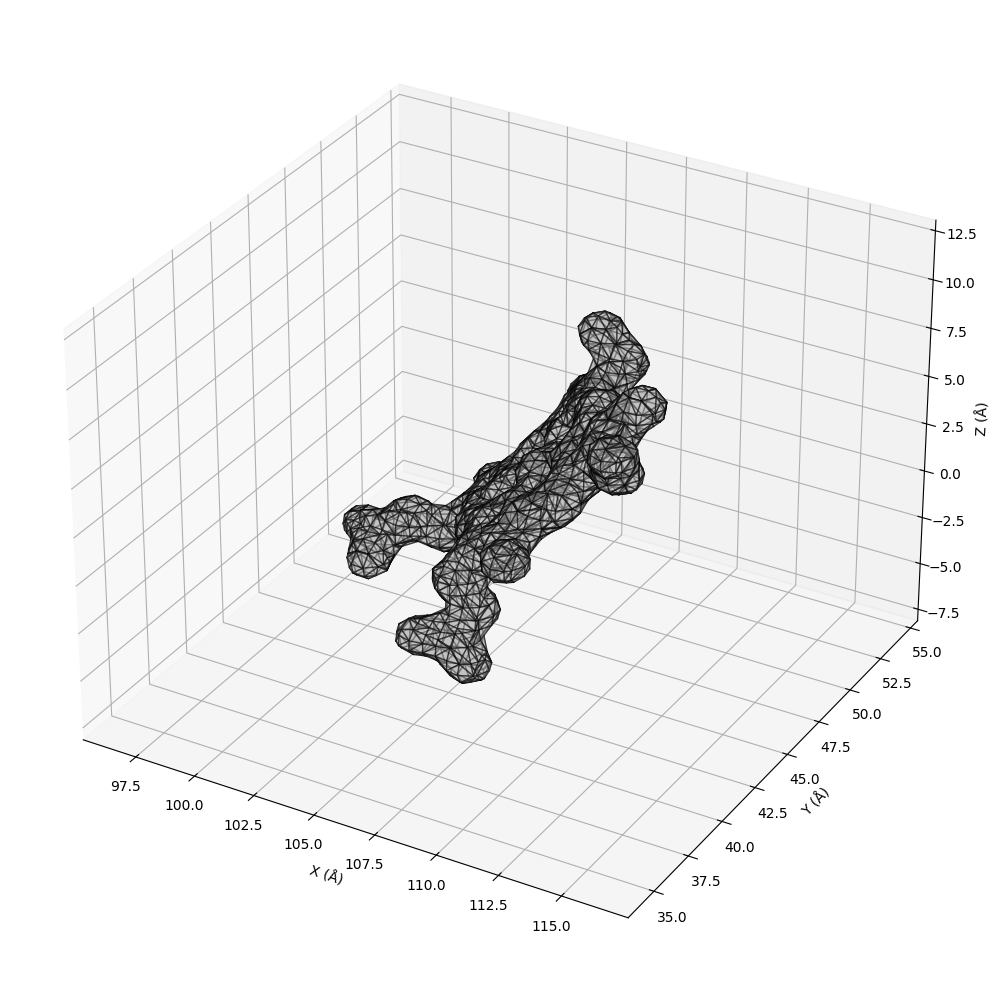

In [8]:
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
import warnings
warnings.filterwarnings('ignore')

class MoleculeDensityVisualizer:
    def __init__(self, pdb_file, grid_spacing=0.5, padding=3.0):
        """
        Initialize the visualizer with a PDB file
        
        Parameters:
        -----------
        pdb_file : str
            Path to the PDB file
        grid_spacing : float
            Resolution of the grid in Angstroms
        padding : float
            Additional space around the molecule in Angstroms
        """
        self.pdb_file = pdb_file
        self.grid_spacing = grid_spacing
        self.padding = padding
        self.atoms = []
        self.grid = None
        self.grid_origin = None
        
        # Atomic radii in Angstroms (van der Waals radii)
        self.atom_radii = {
            'H': 1.20, 'C': 1.70, 'N': 1.55, 'O': 1.52, 'P': 1.80, 'S': 1.80,
            'F': 1.47, 'CL': 1.75, 'BR': 1.85, 'I': 1.98, 'NA': 2.27, 'MG': 1.73,
            'K': 2.75, 'CA': 2.31, 'ZN': 1.39, 'FE': 2.00, 'CU': 1.40
        }
        
        # Default radius for atoms not in the dictionary
        self.default_radius = 1.70
        
    def load_pdb(self):
        """Load atom coordinates and types from a PDB file"""
        self.atoms = []
        
        with open(self.pdb_file, 'r') as f:
            for line in f:
                if line.startswith('ATOM') or line.startswith('HETATM'):
                    # Extract atom information from PDB format
                    atom_type = line[76:78].strip()
                    if not atom_type:
                        atom_type = line[12:14].strip()
                    
                    # Clean up atom type - get just the element
                    atom_type = ''.join([c for c in atom_type if not c.isdigit()]).upper()
                    
                    # Get coordinates
                    x = float(line[30:38].strip())
                    y = float(line[38:46].strip())
                    z = float(line[46:54].strip())
                    
                    # Get radius
                    radius = self.atom_radii.get(atom_type, self.default_radius)
                    
                    self.atoms.append({
                        'type': atom_type,
                        'coords': np.array([x, y, z]),
                        'radius': radius
                    })
                    
        print(f"Loaded {len(self.atoms)} atoms from {self.pdb_file}")
        
    def setup_grid(self):
        """Create a grid around the molecule with appropriate padding"""
        if not self.atoms:
            raise ValueError("No atoms loaded. Call load_pdb() first.")
            
        # Get molecule dimensions
        coords = np.array([atom['coords'] for atom in self.atoms])
        min_coords = np.min(coords, axis=0) - self.padding
        max_coords = np.max(coords, axis=0) + self.padding
        
        # Calculate grid dimensions
        grid_shape = np.ceil((max_coords - min_coords) / self.grid_spacing).astype(int)
        
        # Create empty grid
        self.grid = np.zeros(grid_shape)
        self.grid_origin = min_coords
        
        print(f"Grid dimensions: {grid_shape} ({grid_shape[0]}x{grid_shape[1]}x{grid_shape[2]} voxels)")
        
    def calculate_density(self):
        """Calculate electron density on the grid"""
        if self.grid is None:
            self.setup_grid()
            
        # For each atom, compute contribution to grid points within cutoff distance
        for i, atom in enumerate(self.atoms):
            # Progress indicator
            if i % 100 == 0 and i > 0:
                print(f"Processing atom {i} of {len(self.atoms)}")
                
            # Get atom position and radius
            pos = atom['coords']
            radius = atom['radius']
            
            # Determine grid points to update (bounding box around atom)
            # Convert atom coordinates to grid indices
            atom_grid_pos = (pos - self.grid_origin) / self.grid_spacing
            
            # Calculate the extent of grid points to check (2x radius in each direction)
            # The factor 2.0 ensures we cover enough of the Gaussian
            grid_radius = int(np.ceil(2.0 * radius / self.grid_spacing))
            
            # Calculate bounding box in grid coordinates
            min_grid = np.maximum(np.floor(atom_grid_pos - grid_radius).astype(int), 0)
            max_grid = np.minimum(np.ceil(atom_grid_pos + grid_radius).astype(int), np.array(self.grid.shape) - 1)
            
            # Create a meshgrid for the points to update
            x_indices = np.arange(min_grid[0], max_grid[0] + 1)
            y_indices = np.arange(min_grid[1], max_grid[1] + 1)
            z_indices = np.arange(min_grid[2], max_grid[2] + 1)
            
            xx, yy, zz = np.meshgrid(x_indices, y_indices, z_indices, indexing='ij')
            grid_coords = np.column_stack([xx.flatten(), yy.flatten(), zz.flatten()])
            
            # Convert grid indices back to spatial coordinates
            spatial_coords = grid_coords * self.grid_spacing + self.grid_origin
            
            # Calculate distances from atom to these grid points
            dists = np.linalg.norm(spatial_coords - pos, axis=1)
            
            # Use a Gaussian density function based on distance and atomic radius
            # exp(-d^2 / (2 * (radius/3)^2))
            sigma = radius / 3.0  # Scale factor to control Gaussian width
            densities = np.exp(-dists**2 / (2 * sigma**2))
            
            # Update the grid values
            for (i, j, k), density in zip(grid_coords, densities):
                self.grid[i, j, k] += density
                
        print("Density calculation complete")
        
    def create_surface_mesh(self, iso_value=0.5):
        """Create a surface mesh using marching cubes algorithm"""
        if self.grid is None:
            raise ValueError("No density grid calculated. Call calculate_density() first.")
            
        # Run marching cubes
        verts, faces, normals, _ = measure.marching_cubes(self.grid, iso_value)
        
        # Convert vertices back to real-space coordinates
        verts = verts * self.grid_spacing + self.grid_origin
        
        print(f"Created surface with {len(verts)} vertices and {len(faces)} faces")
        return verts, faces, normals
    
    def visualize_surface(self, verts, faces, normals):
        """Visualize the surface mesh"""
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        # Create mesh
        mesh = Poly3DCollection([verts[face] for face in faces], alpha=0.5)
        face_colors = np.ones((len(faces), 4))
        face_colors[:, 0:3] = 0.7  # Light gray color
        mesh.set_facecolors(face_colors)
        mesh.set_edgecolor('k')
        
        ax.add_collection3d(mesh)
        
        # Set axes limits
        coords = np.array([atom['coords'] for atom in self.atoms])
        min_coords = np.min(coords, axis=0)
        max_coords = np.max(coords, axis=0)
        
        ax.set_xlim(min_coords[0] - 5, max_coords[0] + 5)
        ax.set_ylim(min_coords[1] - 5, max_coords[1] + 5)
        ax.set_zlim(min_coords[2] - 5, max_coords[2] + 5)
        
        ax.set_xlabel('X (Å)')
        ax.set_ylabel('Y (Å)')
        ax.set_zlabel('Z (Å)')
        
        plt.tight_layout()
        return fig
    
    def process_molecule(self, iso_value=0.5):
        """Process the molecule: load PDB, calculate density, create surface"""
        self.load_pdb()
        self.setup_grid()
        self.calculate_density()
        verts, faces, normals = self.create_surface_mesh(iso_value)
        fig = self.visualize_surface(verts, faces, normals)
        return fig

pdb_file =r'D:\PythonProj\heme.pdb'  
    
visualizer = MoleculeDensityVisualizer(pdb_file, grid_spacing=0.5, padding=3.0)
fig = visualizer.process_molecule(iso_value=0.3)
plt.show()
    
    # Optionally save the figure
    # fig.savefig("molecule_surface.png", dpi=300)